In [1]:
from tensorflow.keras.layers import Input, Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dense, Concatenate, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.models import Model
import tensorflow as tf
import nltk
import cv2
nltk.download('words')
from nltk.corpus import words
from keras.layers import Lambda
from keras.layers import BatchNormalization
from keras.initializers import he_normal
from keras.layers import LeakyReLU
from keras.constraints import max_norm
from keras.regularizers import l1
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow.keras.layers
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import Accuracy
import pandas as pd
import os
import glob
import numpy as np
from PIL import Image
import random
from random import randint
import math
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import RMSprop, Adam, SGD
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy, Precision, Recall

2024-05-08 13:41:06.143664: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-08 13:41:06.143776: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-08 13:41:06.263539: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


[nltk_data] Downloading package words to /usr/share/nltk_data...
[nltk_data]   Package words is already up-to-date!


In [2]:
file_path = '/kaggle/input/lung-disease-clinical-texts-and-image-processed/lung_disease_clinical_texts_processed.csv'
data_frame = pd.read_csv(file_path)

data_frame.head()

,clinical_text,disease
0,I have a chronic cough that is. It ' s very ha...,Obstructive Pulmonary Diseases
1,'It a headache and a throat. I got and chills....,Obstructive Pulmonary Diseases
2,I have been coughing up blood for a while now....,Obstructive Pulmonary Diseases
3,I had a sharp in chest and arm made me gasp. I...,Obstructive Pulmonary Diseases
4,I don ' t know what ' s wrong with me. I have ...,Obstructive Pulmonary Diseases


In [3]:
unique_diseases = data_frame['disease'].unique()
print(unique_diseases)

['Obstructive Pulmonary Diseases' 'Higher Density' 'Lower Density'
 'Chest Changes' 'Encapsulated Lesions' 'Degenerative Infectious Diseases'
 'Normal' 'Mediastinal Changes']


In [4]:
# Rename the 'disease' column to 'label' in the data_frame DataFrame
data_frame.rename(columns={'disease': 'label'}, inplace=True)

# Display the DataFrame to verify the column name change
data_frame.head()

,clinical_text,label
0,I have a chronic cough that is. It ' s very ha...,Obstructive Pulmonary Diseases
1,'It a headache and a throat. I got and chills....,Obstructive Pulmonary Diseases
2,I have been coughing up blood for a while now....,Obstructive Pulmonary Diseases
3,I had a sharp in chest and arm made me gasp. I...,Obstructive Pulmonary Diseases
4,I don ' t know what ' s wrong with me. I have ...,Obstructive Pulmonary Diseases


In [5]:
print("Number of unique values in 'clinical_text' column:", data_frame['clinical_text'].nunique())

Number of unique values in 'clinical_text' column: 8000


In [6]:
def create_augmented_df(path, target_shape=(256, 256)):
    classes = os.listdir(path)  # Get the list of class directories
    data = []  # List to store image data and class labels
    
    # Read and store each image and its class
    for cls in classes:
        for file in glob.glob(f"{path}/{cls}/*"):
            if file.endswith(('png', 'jpeg', 'jpg')):
                # Open the image file
                image = Image.open(file)
                
                # Resize the image to the target shape
                resized_image = image.resize(target_shape)
                
                # Append the resized image and its class to the list
                data.append((resized_image, cls))
                
                # Data augmentation - horizontal flip
                flipped_image = resized_image.transpose(Image.FLIP_LEFT_RIGHT)
                data.append((flipped_image, cls))  # Append the augmented image and its class
    
    # Create a DataFrame
    df = pd.DataFrame(data, columns=['image', 'label'])
    
    return df

In [7]:
image_data = create_augmented_df('/kaggle/input/x-ray-lung-diseases-images-9-classes')

In [8]:
image_data.head()

,image,label
0,<PIL.Image.Image image mode=RGB size=256x256 a...,"04 Doenças Pulmonares Obstrutivas (Enfisema, B..."
1,<PIL.Image.Image image mode=RGB size=256x256 a...,"04 Doenças Pulmonares Obstrutivas (Enfisema, B..."
2,<PIL.Image.Image image mode=RGB size=256x256 a...,"04 Doenças Pulmonares Obstrutivas (Enfisema, B..."
3,<PIL.Image.Image image mode=RGB size=256x256 a...,"04 Doenças Pulmonares Obstrutivas (Enfisema, B..."
4,<PIL.Image.Image image mode=RGB size=256x256 a...,"04 Doenças Pulmonares Obstrutivas (Enfisema, B..."


In [9]:
class_counts = image_data['label'].value_counts()
print(class_counts)

label
00 Anatomia Normal                                                                           2680
01 Processos Inflamatórios Pulmonares (Pneumonia)                                            2120
02 Maior Densidade (Derrame Pleural, Consolidação Atelectasica, Hidrotorax, Empiema)         1342
06 Lesões Encapsuladas (Abscessos, Nódulos, Cistos, Massas Tumorais, Metastases)             1316
04 Doenças Pulmonares Obstrutivas (Enfisema, Broncopneumonia, Bronquiectasia, Embolia)       1274
03 Menor Densidade (Pneumotorax, Pneumomediastino, Pneumoperitonio)                          1258
07 Alterações de Mediastino (Pericardite, Malformações Arteriovenosas, Linfonodomegalias)    1192
05 Doenças Infecciosas Degenerativas (Tuberculose, Sarcoidose, Proteinose, Fibrose)          1160
08 Alterações do Tórax (Atelectasias, Malformações, Agenesia, Hipoplasias)                   1088
Name: count, dtype: int64


In [10]:
# Define a dictionary to map disease names from different languages to English short names
disease_mapping = {
    "00 Anatomia Normal": "Normal",
    "01 Processos Inflamatórios Pulmonares (Pneumonia)": "Inflammatory Processes",
    "02 Maior Densidade (Derrame Pleural, Consolidação Atelectasica, Hidrotorax, Empiema)": "Higher Density",
    "06 Lesões Encapsuladas (Abscessos, Nódulos, Cistos, Massas Tumorais, Metastases)": "Encapsulated Lesions",
    "04 Doenças Pulmonares Obstrutivas (Enfisema, Broncopneumonia, Bronquiectasia, Embolia)": "Obstructive Pulmonary Diseases",
    "03 Menor Densidade (Pneumotorax, Pneumomediastino, Pneumoperitonio)": "Lower Density",
    "07 Alterações de Mediastino (Pericardite, Malformações Arteriovenosas, Linfonodomegalias)": "Mediastinal Changes",
    "05 Doenças Infecciosas Degenerativas (Tuberculose, Sarcoidose, Proteinose, Fibrose)": "Degenerative Infectious Diseases",
    "08 Alterações do Tórax (Atelectasias, Malformações, Agenesia, Hipoplasias)": "Chest Changes"
}

# Replace the values in the 'Class' column of df with their corresponding English short names
image_data['label'] = image_data['label'].replace(disease_mapping)

In [11]:
class_counts = image_data['label'].value_counts()
print(class_counts)

label
Normal                              2680
Inflammatory Processes              2120
Higher Density                      1342
Encapsulated Lesions                1316
Obstructive Pulmonary Diseases      1274
Lower Density                       1258
Mediastinal Changes                 1192
Degenerative Infectious Diseases    1160
Chest Changes                       1088
Name: count, dtype: int64


In [12]:
image_data.shape

(13430, 2)

In [13]:
image_data.head()

,image,label
0,<PIL.Image.Image image mode=RGB size=256x256 a...,Obstructive Pulmonary Diseases
1,<PIL.Image.Image image mode=RGB size=256x256 a...,Obstructive Pulmonary Diseases
2,<PIL.Image.Image image mode=RGB size=256x256 a...,Obstructive Pulmonary Diseases
3,<PIL.Image.Image image mode=RGB size=256x256 a...,Obstructive Pulmonary Diseases
4,<PIL.Image.Image image mode=RGB size=256x256 a...,Obstructive Pulmonary Diseases


In [14]:
def balance_data(image_data):
    # Remove rows with 'Inflammatory Processes' label
    image_data = image_data[image_data['label'] != 'Inflammatory Processes']
    
    # Sample 1000 rows for each label
    labels = image_data['label'].unique()
    sampled_data = pd.DataFrame()
    for label in labels:
        label_data = image_data[image_data['label'] == label]
        if len(label_data) > 1000:
            label_data = label_data.sample(n=1000, random_state=42)
        sampled_data = pd.concat([sampled_data, label_data])
    
    return sampled_data

In [15]:
image_data = balance_data(image_data)
class_counts = image_data['label'].value_counts()
print(class_counts)

label
Obstructive Pulmonary Diseases      1000
Higher Density                      1000
Lower Density                       1000
Chest Changes                       1000
Encapsulated Lesions                1000
Degenerative Infectious Diseases    1000
Normal                              1000
Mediastinal Changes                 1000
Name: count, dtype: int64


In [16]:
image_data.reset_index(drop=True, inplace=True)
image_data.head()

,image,label
0,<PIL.Image.Image image mode=RGB size=256x256 a...,Obstructive Pulmonary Diseases
1,<PIL.Image.Image image mode=L size=256x256 at ...,Obstructive Pulmonary Diseases
2,<PIL.Image.Image image mode=RGB size=256x256 a...,Obstructive Pulmonary Diseases
3,<PIL.Image.Image image mode=RGB size=256x256 a...,Obstructive Pulmonary Diseases
4,<PIL.Image.Image image mode=L size=256x256 at ...,Obstructive Pulmonary Diseases


In [17]:
print(image_data.loc[0, 'image'])
print(image_data.loc[1, 'image'])
print(data_frame.loc[0, 'clinical_text'])
print(data_frame.loc[1, 'clinical_text'])

<PIL.Image.Image image mode=RGB size=256x256 at 0x79B4DCA54E50>
<PIL.Image.Image image mode=L size=256x256 at 0x79B4DCA94940>
I have a chronic cough that is. It ' s very hard to breathe and I a lot of mucus and blood my. It ' s very and it makes me spit. I also have a lot of chest pain and crackling. I feel very tired and I have lost lot. My nails are also abnormal, they are thick and curved.
'It a headache and a throat. I got and chills. I had trouble breathing and I felt dizzy. My was and I was coughing up mucus. I felt confused and.'


In [18]:
# Sort the 'label' column of data_frame in alphabetical order and reset index
data_frame = data_frame.sort_values(by='label').reset_index(drop=True)

# Sort the 'label' column of image_data in alphabetical order and reset index
image_data = image_data.sort_values(by='label').reset_index(drop=True)

# Display the sorted DataFrames
print("Sorted data_frame:")
print(data_frame.head())

print("\nSorted image_data:")
print(image_data.head())

Sorted data_frame:
                                       clinical_text          label
0  I feel like less air in my lungs than normal. ...  Chest Changes
1  I ' ve been coughing a lot thick. I have fever...  Chest Changes
2  'My, harp, and my voice, shall be exceeding lo...  Chest Changes
3  'I was feeling weird in my body, allergic to m...  Chest Changes
4  I have been suffering from frequent lung infec...  Chest Changes

Sorted image_data:
                                               image          label
0  <PIL.Image.Image image mode=RGB size=256x256 a...  Chest Changes
1  <PIL.Image.Image image mode=RGB size=256x256 a...  Chest Changes
2  <PIL.Image.Image image mode=L size=256x256 at ...  Chest Changes
3  <PIL.Image.Image image mode=RGB size=256x256 a...  Chest Changes
4  <PIL.Image.Image image mode=RGB size=256x256 a...  Chest Changes


In [19]:
print(data_frame.shape)
print(image_data.shape)

(8000, 2)
(8000, 2)


In [20]:
print(image_data.loc[0, 'image'])
print(image_data.loc[1, 'image'])
print(data_frame.loc[0, 'clinical_text'])
print(data_frame.loc[1, 'clinical_text'])

<PIL.Image.Image image mode=RGB size=256x256 at 0x79B4DC72A4D0>
<PIL.Image.Image image mode=RGB size=256x256 at 0x79B4DC7669E0>
I feel like less air in my lungs than normal. I temperature and chest pain. I cough phlegm and hear some sounds when I breathe. My breathing is shallow fast. My chest ' t move when I breathe.
I ' ve been coughing a lot thick. I have fever and. My fast and shallow. I hear some wheezing sounds in my chest. My doesn ' t move when I breathe.


In [21]:
def compute_label_similarity(data_frame, image_data):
    # Assuming 'data_frame' and 'image_data' are your datasets
    # Replace these lines with loading your actual datasets
    
    # Example data for demonstration
    data_frame = pd.DataFrame(data_frame)
    image_data = pd.DataFrame(image_data)
    
    # Check if 'label' column exists in both datasets
    if 'label' not in data_frame.columns or 'label' not in image_data.columns:
        raise ValueError("Both datasets must contain a column named 'label'")
    
    # Count the number of matching labels
    matching_labels = sum(data_frame['label'] == image_data['label'])
    
    # Calculate the percentage of matching labels
    total_labels = len(data_frame)
    similarity_percentage = (matching_labels / total_labels) * 100
    
    return similarity_percentage

In [22]:
try:
    percentage_similarity = compute_label_similarity(data_frame, image_data)
    print("Percentage of label similarity:", percentage_similarity)
except ValueError as e:
    print(e)

Percentage of label similarity: 100.0


In [23]:
print("Data Frame Label Counts:", data_frame['label'].value_counts())
print("Image Data Label Counts:", image_data['label'].value_counts())

Data Frame Label Counts: label
Chest Changes                       1000
Degenerative Infectious Diseases    1000
Encapsulated Lesions                1000
Higher Density                      1000
Lower Density                       1000
Mediastinal Changes                 1000
Normal                              1000
Obstructive Pulmonary Diseases      1000
Name: count, dtype: int64
Image Data Label Counts: label
Chest Changes                       1000
Degenerative Infectious Diseases    1000
Encapsulated Lesions                1000
Higher Density                      1000
Lower Density                       1000
Mediastinal Changes                 1000
Normal                              1000
Obstructive Pulmonary Diseases      1000
Name: count, dtype: int64


In [24]:
# Remove the common column 'label' from 'image_data'
data_frame = data_frame.drop(columns=['label'])
# Concatenate the datasets column-wise
merged_data = pd.concat([data_frame, image_data], axis=1)

merged_data.head()

,clinical_text,image,label
0,I feel like less air in my lungs than normal. ...,<PIL.Image.Image image mode=RGB size=256x256 a...,Chest Changes
1,I ' ve been coughing a lot thick. I have fever...,<PIL.Image.Image image mode=RGB size=256x256 a...,Chest Changes
2,"'My, harp, and my voice, shall be exceeding lo...",<PIL.Image.Image image mode=L size=256x256 at ...,Chest Changes
3,"'I was feeling weird in my body, allergic to m...",<PIL.Image.Image image mode=RGB size=256x256 a...,Chest Changes
4,I have been suffering from frequent lung infec...,<PIL.Image.Image image mode=RGB size=256x256 a...,Chest Changes


In [25]:
merged_data.shape

(8000, 3)

In [26]:
merged_data.sample(frac=1, random_state=4200).reset_index(drop=True)

,clinical_text,image,label
0,I have a horrible cough that has been going on...,<PIL.Image.Image image mode=RGB size=256x256 a...,Degenerative Infectious Diseases
1,I ' m suffering a lot of pain my abdomen. ' s ...,<PIL.Image.Image image mode=L size=256x256 at ...,Lower Density
2,"I have fever, I ' m shaking a lot. I cough, I ...",<PIL.Image.Image image mode=RGB size=256x256 a...,Obstructive Pulmonary Diseases
3,'I coughed a lot and produced a thick mucus. I...,<PIL.Image.Image image mode=L size=256x256 at ...,Chest Changes
4,"I don ' t feel like eating anything, and I ' m...",<PIL.Image.Image image mode=RGB size=256x256 a...,Degenerative Infectious Diseases
...,...,...,...
7995,"I ' m, and I a in my. I also have a fever, a c...",<PIL.Image.Image image mode=RGB size=256x256 a...,Higher Density
7996,I have nodules in my and I have symptoms that ...,<PIL.Image.Image image mode=L size=256x256 at ...,Encapsulated Lesions
7997,"'I had a fever, I sweated lot. I coughed, I co...",<PIL.Image.Image image mode=L size=256x256 at ...,Obstructive Pulmonary Diseases
7998,'Have a common cough that is very annoying. It...,<PIL.Image.Image image mode=L size=256x256 at ...,Obstructive Pulmonary Diseases


In [27]:
merged_data_array = merged_data.to_numpy()  # Convert DataFrame to NumPy array
np.random.shuffle(merged_data_array)  # Shuffle the array in-place
merged_data = pd.DataFrame(merged_data_array, columns=merged_data.columns) 
merged_data

,clinical_text,image,label
0,"'For the past few weeks, I have had and a. I a...",<PIL.Image.Image image mode=RGB size=256x256 a...,Mediastinal Changes
1,"'I have short breathing and chest pain, and I ...",<PIL.Image.Image image mode=L size=256x256 at ...,Higher Density
2,I ' feeling very unwell. have a lot of pain in...,<PIL.Image.Image image mode=RGB size=256x256 a...,Lower Density
3,"My skin turned pale and clammy, and I felt a r...",<PIL.Image.Image image mode=L size=256x256 at ...,Obstructive Pulmonary Diseases
4,"'A sound was gone out on it, and I heard the s...",<PIL.Image.Image image mode=L size=256x256 at ...,Obstructive Pulmonary Diseases
...,...,...,...
7995,'I trouble breathing. have a phlegmy cough. I ...,<PIL.Image.Image image mode=L size=256x256 at ...,Lower Density
7996,I have a lung that is fully developed and it a...,<PIL.Image.Image image mode=L size=256x256 at ...,Chest Changes
7997,I ' ve been feeling sick for a long time. I a ...,<PIL.Image.Image image mode=RGB size=256x256 a...,Degenerative Infectious Diseases
7998,I've had a lot of fever and sweat. I've been c...,<PIL.Image.Image image mode=RGB size=256x256 a...,Obstructive Pulmonary Diseases


In [28]:
print("Number of unique values in 'clinical_text' column:", merged_data['clinical_text'].nunique())

Number of unique values in 'clinical_text' column: 8000


In [29]:
print(merged_data.loc[0, 'image'])
print(merged_data.loc[1, 'image'])
print(merged_data.loc[0, 'clinical_text'])
print(merged_data.loc[1, 'clinical_text'])

<PIL.Image.Image image mode=RGB size=256x256 at 0x79B4DC5B1360>
<PIL.Image.Image image mode=L size=256x256 at 0x79B4DC984850>
'For the past few weeks, I have had and a. I also have a bad cold with nose and a throat. When I checked my neck, I felt some lumps that were hard and growing fast. think they are lymph nodes. it be?'
'I have short breathing and chest pain, and I also have fever, cough, and hiccups.'


In [30]:
word_list = words.words()

# Function to add random words to a sentence
def add_random_words(sentence):
    words = sentence.split()
    num_words_to_add = random.randint(1, 5)  # Randomly choose the number of words to add
    for _ in range(num_words_to_add):
        random_word = random.choice(word_list)  # Select a random word from the library
        position = random.randint(0, len(words))  # Randomly choose a position to insert the word
        words.insert(position, random_word)
    return ' '.join(words)

# Function to rotate image
def rotate_image(image):
    return image.rotate(randint(1, 360))

In [31]:
# Augment text data
augmented_text_data = []
for index, row in merged_data.iterrows():
    original_sentence = row['clinical_text']
    original_label = row['label']
    for _ in range(7):  # Create four variations for each original sentence
        new_sentence = add_random_words(original_sentence)
        augmented_text_data.append({'clinical_text': new_sentence, 'label': original_label})

In [32]:
# Augment image data
augmented_image_data = []
for index, row in merged_data.iterrows():
    original_image = row['image']
    original_label = row['label']
    for _ in range(7):  # Create four variations for each original image
        rotated_image = rotate_image(original_image)
        augmented_image_data.append({'image': rotated_image, 'label': original_label})


In [33]:
# Convert augmented data to DataFrame
augmented_text_df = pd.DataFrame(augmented_text_data)
augmented_image_df = pd.DataFrame(augmented_image_data)

In [34]:
percentage_similarity = compute_label_similarity(augmented_text_df, augmented_image_df)
print("Percentage of label similarity:", percentage_similarity)

Percentage of label similarity: 100.0


In [35]:
# Combine text and image dataframes
augmented_text_df = augmented_text_df.drop(columns=['label'])
augmented_merged_data = pd.concat([augmented_text_df, augmented_image_df], axis=1)

# Shuffle the augmented data
augmented_merged_data = augmented_merged_data.sample(frac=1, random_state=42).reset_index(drop=True)

In [36]:
augmented_merged_data

,clinical_text,image,label
0,I ' m Samydaceae experiencing sicknessproof a ...,<PIL.Image.Image image mode=L size=256x256 at ...,Lower Density
1,I have horrible pain my belly. It ' s a crampi...,<PIL.Image.Image image mode=L size=256x256 at ...,Lower Density
2,'I also agalaxy have a loss of vision. I see t...,<PIL.Image.Image image mode=RGB size=256x256 a...,Mediastinal Changes
3,"I have been wheezing jet a lot lately, and I d...",<PIL.Image.Image image mode=L size=256x256 at ...,Obstructive Pulmonary Diseases
4,"'For I will strike Shrine through my nose, and...",<PIL.Image.Image image mode=L size=256x256 at ...,Mediastinal Changes
...,...,...,...
55995,"'I am, neither am, neither am: I am but; yet I...",<PIL.Image.Image image mode=RGB size=256x256 a...,Normal
55996,I ' ve got fever and I ' m Jatni shaking so mu...,<PIL.Image.Image image mode=L size=256x256 at ...,Obstructive Pulmonary Diseases
55997,'I have fever and chest pain. I sputum hear wh...,<PIL.Image.Image image mode=L size=256x256 at ...,Chest Changes
55998,'I been severe unsteadiness for the. I lose my...,<PIL.Image.Image image mode=L size=256x256 at ...,Mediastinal Changes


In [37]:
merged_data = augmented_merged_data


In [38]:
# Define a mapping from string labels to numerical labels
label_mapping = {
    'Obstructive Pulmonary Diseases': 0,
    'Higher Density': 1,
    'Lower Density': 2,
    'Chest Changes': 3,
    'Encapsulated Lesions': 4,
    'Degenerative Infectious Diseases': 5,
    'Normal': 6,
    'Mediastinal Changes': 7
}

In [39]:
# Extract labels, texts, and images from merged_data
labels = []
texts = []
images = []

for index, row in merged_data.iterrows():
    label = row['label']
    text = row['clinical_text']
    image = row['image']
    
    numerical_label = label_mapping[label]
    
    labels.append(numerical_label)
    texts.append(text)
    images.append(image)

In [40]:
# Tokenize texts
max_len = 500
max_words = 10000

In [41]:
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))
data = pad_sequences(sequences, maxlen=max_len)
print('Shape of data tensor:', data.shape)

Found 121123 unique tokens.
Shape of data tensor: (56000, 500)


In [42]:
# decode the words
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
decoded_review = ' '.join([reverse_word_index.get(i, '?') for i in sequences[0]])

In [43]:
decoded_review

"i ' m experiencing a lot of discomfort in my stomach it ' s a sharp pain i also nausea my stomach tender i have a and heart rate i feel low blood i ' m concerned"

In [44]:
image_width = 256
image_height = 256

In [45]:
# Convert labels to numpy array
labels = np.array(labels)

# Convert images to numpy arrays
image_arrays = []

for img in images:
    # Convert image to numpy array
    img_array = np.array(img)
    # Check if the image is grayscale
    if len(img_array.shape) == 2:
        img_gray = img_array  # Already grayscale, no need to convert
    else:
        # Convert RGB image to grayscale
        img_gray = cv2.cvtColor(img_array, cv2.COLOR_RGB2GRAY)
    # Resize
    img_resized = cv2.resize(img_gray, (image_width, image_height))
    image_arrays.append(img_resized)

images = np.array(image_arrays)

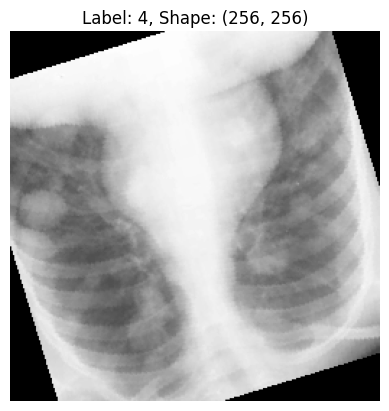

In [46]:
# Randomly select an index
random_index = np.random.randint(0, len(images))

# Select the image and its corresponding label
random_image = images[random_index]
random_label = labels[random_index]

# Plot the image
plt.imshow(random_image, cmap='gray')  # Assuming the images are grayscale
plt.title(f'Label: {random_label}, Shape: {random_image.shape}')
plt.axis('off')
plt.show()

In [47]:
# Define the percentage of samples for training and validation
train_percentage = 0.7  # 70% of the data for training
val_percentage = 0.2    # 20% of the data for validation

# Calculate the total number of samples
total_samples = len(merged_data)

# Calculate the number of samples for training and validation based on percentages
training_samples = int(train_percentage * total_samples)
validation_samples = int(val_percentage * total_samples)

In [48]:
# Split data for text
x_train_text = data[:training_samples]
y_train_text = labels[:training_samples]
x_val_text = data[training_samples:training_samples + validation_samples]
y_val_text = labels[training_samples:training_samples + validation_samples]
x_test_text = data[training_samples + validation_samples:]
y_test_text = labels[training_samples + validation_samples:]

# Split data for images
x_train_image = images[:training_samples]
y_train_image = labels[:training_samples]
x_val_image = images[training_samples:training_samples + validation_samples]
y_val_image = labels[training_samples:training_samples + validation_samples]
x_test_image = images[training_samples + validation_samples:]
y_test_image = labels[training_samples + validation_samples:]

In [49]:
def normalize_data(data):
    min_val = np.nanmin(data)
    max_val = np.nanmax(data)
    range_val = max_val - min_val
    data = (data - min_val) / range_val

    data[np.isnan(data)] = 0.0001
    data[data == 0] = 0.0001
    return data

In [50]:
#x_train_image = normalize_data(x_train_image)
#x_val_image = normalize_data(x_val_image)
#x_test_image = normalize_data(x_test_image)

In [51]:
# Print shapes of the datasets
print("Text Data Shapes:")
print("Training:", x_train_text.shape, y_train_text.shape)
print("Validation:", x_val_text.shape, y_val_text.shape)
print("Test:", x_test_text.shape, y_test_text.shape)

print("\nImage Data Shapes:")
print("Training:", x_train_image.shape, y_train_image.shape)
print("Validation:", x_val_image.shape, y_val_image.shape)
print("Test:", x_test_image.shape, y_test_image.shape)

Text Data Shapes:
Training: (39200, 500) (39200,)
Validation: (11200, 500) (11200,)
Test: (5600, 500) (5600,)

Image Data Shapes:
Training: (39200, 256, 256) (39200,)
Validation: (11200, 256, 256) (11200,)
Test: (5600, 256, 256) (5600,)


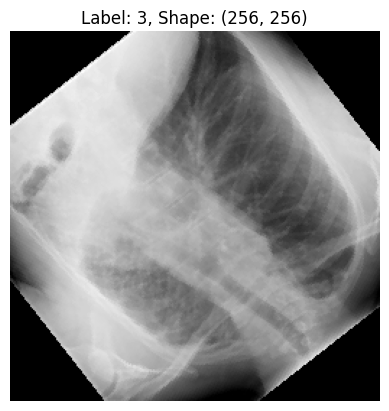

In [52]:
# Randomly select an index
random_index = np.random.randint(0, len(x_train_image))

# Select the image and its corresponding label
random_image = x_train_image[random_index]
random_label = labels[random_index]

# Plot the image
plt.imshow(random_image, cmap='gray')  # Assuming the images are grayscale
plt.title(f'Label: {random_label}, Shape: {random_image.shape}')
plt.axis('off')
plt.show()

In [53]:
activation = LeakyReLU(negative_slope=0.1)  # You can adjust the slope (alpha) as needed

# Text input
text_input_layer = Input(shape=(500,))
embedding_layer = Embedding(max_words, 50)(text_input_layer)
normalized_embedding = BatchNormalization()(embedding_layer)  # Add BatchNormalization layer
replace_zeros = Lambda(lambda x: tf.where(tf.equal(x, 0), 0.001 * tf.ones_like(x), x))(normalized_embedding)
replace_nan = Lambda(lambda x: tf.where(tf.math.is_nan(x), 0.001 * tf.ones_like(x), x))(replace_zeros)
text_layer = Conv1D(256, 3, activation=activation, kernel_regularizer=l1(1e-10))(replace_nan)
text_layer = MaxPooling1D(3)(text_layer)
text_layer = Conv1D(256, 3, activation=activation, kernel_regularizer=l1(1e-10))(text_layer)
text_layer = MaxPooling1D(3)(text_layer)
text_layer = Conv1D(256, 3, activation=activation, kernel_regularizer=l1(1e-10))(text_layer)
text_layer = MaxPooling1D(3)(text_layer)
text_layer = Conv1D(256, 3, activation=activation, kernel_regularizer=l1(1e-10))(text_layer)
text_layer = MaxPooling1D(3)(text_layer)
text_layer = Conv1D(256, 3, activation=activation , kernel_regularizer=l1(1e-10))(text_layer)
text_layer = MaxPooling1D(3)(text_layer)
text_layer = Flatten()(text_layer)
text_layer = Dense(512, activation=activation , kernel_regularizer=l1(1e-10))(text_layer)

# Image input
image_input_layer = Input(shape=(256, 256, 1))
image_input_layer = BatchNormalization()(image_input_layer)
replace_zeros_image = Lambda(lambda x: tf.where(tf.equal(x, 0), 0.001 * tf.ones_like(x), x))(image_input_layer)
replace_nan_image = Lambda(lambda x: tf.where(tf.math.is_nan(x), 0.001 * tf.ones_like(x), x))(replace_zeros_image)
image_layer = Conv2D(256, (3, 3), activation=activation, kernel_regularizer=l1(1e-10))(replace_nan_image)
image_layer = MaxPooling2D((2, 2))(image_layer)
image_layer = Conv2D(256, (3, 3), activation=activation, kernel_regularizer=l1(1e-10))(image_layer)
image_layer = MaxPooling2D((2, 2))(image_layer)
image_layer = Conv2D(256, (3, 3), activation=activation, kernel_regularizer=l1(1e-10))(image_layer)
image_layer = MaxPooling2D((2, 2))(image_layer)
image_layer = Conv2D(256, (3, 3), activation=activation, kernel_regularizer=l1(1e-10))(image_layer)
image_layer = MaxPooling2D((2, 2))(image_layer)
image_layer = Conv2D(256, (3, 3), activation=activation, kernel_regularizer=l1(1e-10))(image_layer)
image_layer = MaxPooling2D((2, 2))(image_layer)
image_layer = Flatten()(image_layer)
#image_layer = Dense(512, activation=activation, kernel_regularizer=l1(1e-5))(image_layer)

# Concatenate text and image branches
concatenated_layer = Concatenate()([text_layer, image_layer])
#kernel_regularizer=l1(1e-10)
# Dense layers
dense_layer = Dense(512, activation=activation, kernel_regularizer=l1(1e-10))(concatenated_layer)
dense_layer = Dense(1024, activation=activation, kernel_regularizer=l1(1e-10))(dense_layer)
dense_layer = Dense(2048, activation=activation, kernel_regularizer=l1(1e-10))(dense_layer)
output_layer = Dense(1, activation='sigmoid')(dense_layer)

# Define the model with two inputs
model = Model(inputs=[text_input_layer, image_input_layer], outputs=output_layer)
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 500)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 500, 50)   │    500,000 │ input_layer[2][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 500, 50)   │        200 │ embedding[2][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 500, 50)   │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ keras_tensor_22CLO… │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_1 (Lambda)   │ (None, 500, 50)   │          0 │ lambda[2][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_2 (Lambda)   │ (None, 256, 256,  │          0 │ keras_tensor_22C… │
│                     │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 498, 256)  │     38,656 │ lambda_1[2][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_3 (Lambda)   │ (None, 256, 256,  │          0 │ lambda_2[2][0]    │
│                     │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, 166, 256)  │          0 │ conv1d[2][0]      │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 254, 254,  │      2,560 │ lambda_3[2][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 164, 256)  │    196,864 │ max_pooling1d[2]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 127, 127,  │          0 │ conv2d[2][0]      │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_1     │ (None, 54, 256)   │          0 │ conv1d_1[2][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 125, 125,  │    590,080 │ max_pooling2d[2]… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 52, 256)   │    196,864 │ max_pooling1d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 62, 62,    │          0 │ conv2d_1[2][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_2     │ (None, 17, 256)   │          0 │ conv1d_2[2][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 11,428,585 (43.60 MB)

 Trainable params: 11,428,485 (43.60 MB)

 Non-trainable params: 100 (400.00 B)

In [54]:
model1 = model
model2 = model

In [55]:
# Save the summary to a text file
with open('model_summary.txt', 'w') as f:
    model.summary(print_fn=lambda x: f.write(x + '\n'))

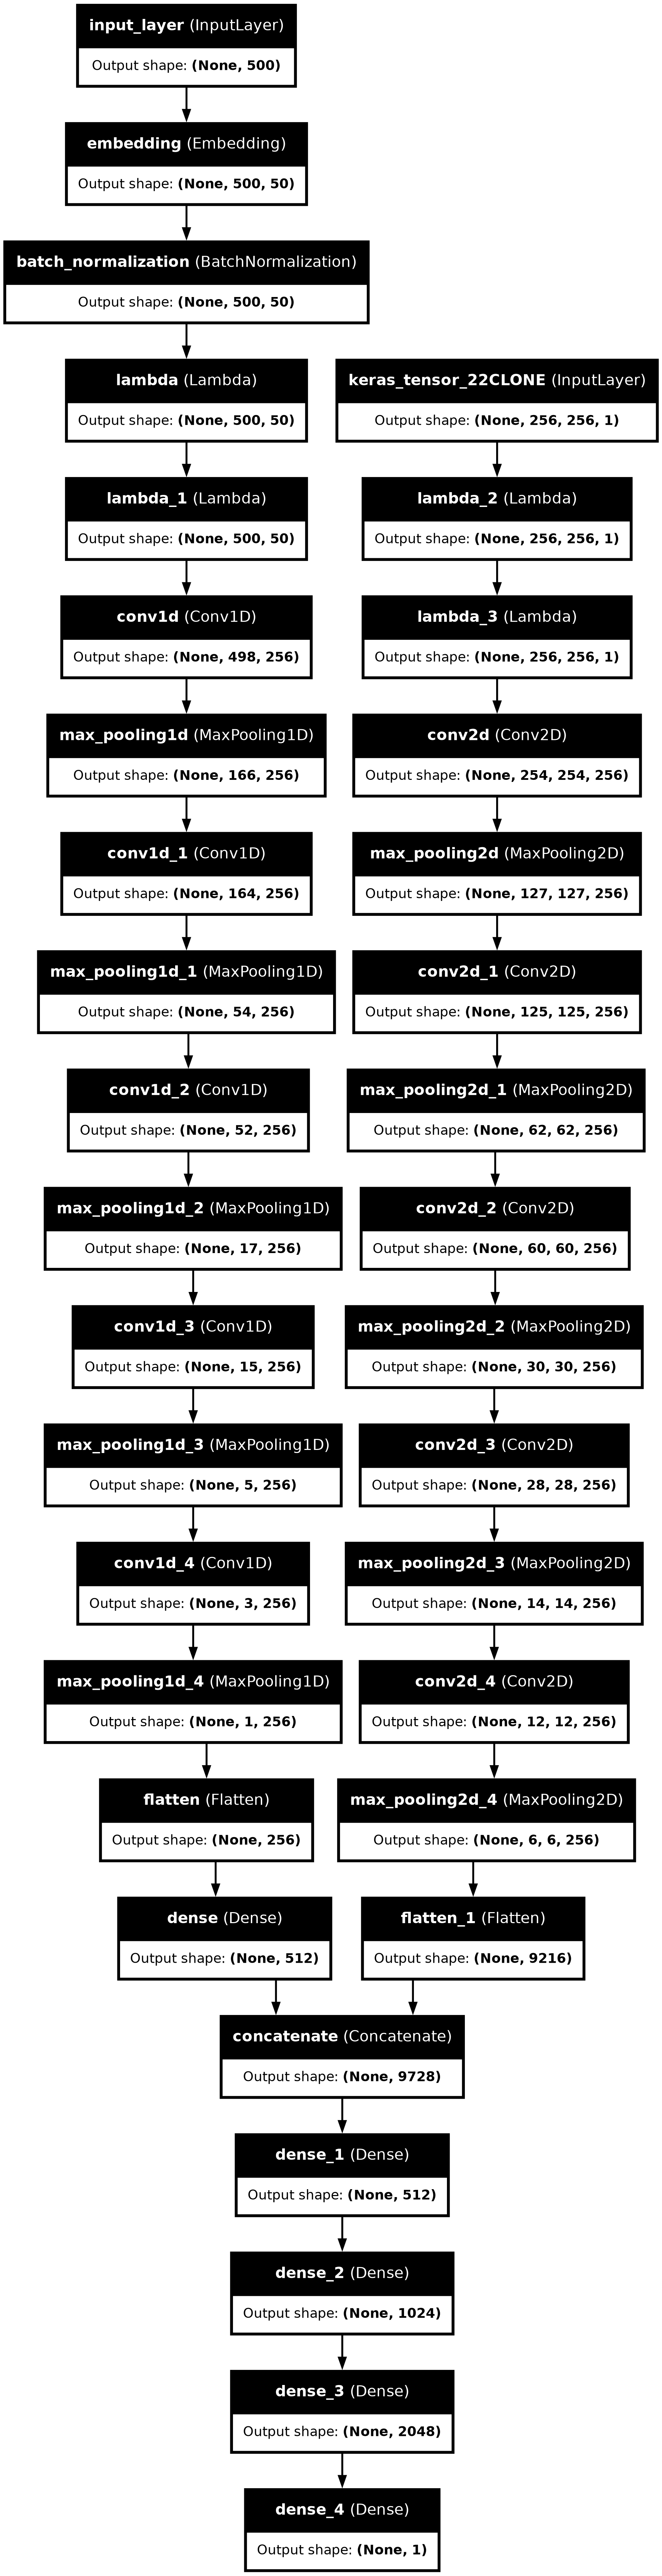

In [56]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [57]:
epochs = 10
batch_size = 16

In [58]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

# Define callbacks
early_stopping = EarlyStopping(monitor='categorical_accuracy', patience=5)
model_checkpoint = ModelCheckpoint('model.keras', save_best_only=True) 

# Add callbacks to a list
callback_list = [model_checkpoint]

In [59]:
optimizer = Adam(learning_rate=0.0001, clipnorm=1.0)
loss_function = CategoricalCrossentropy()

model.compile(optimizer=optimizer,
              loss=loss_function,
              metrics=[CategoricalAccuracy()])

In [60]:
# Fit the model with both text and image inputs and their respective labels
history = model.fit([x_train_text, x_train_image], [y_train_text, y_train_image],
                    epochs=epochs, batch_size=batch_size, callbacks=callback_list,
                    validation_data=([x_val_text, x_val_image], [y_val_text, y_val_image]))

Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/losses/losses.py:22: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(16, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return self.fn(y_true, y_pred, **self._fn_kwargs)
I0000 00:00:1715175827.085550      77 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1715175827.111379      77 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1715175827.114426      77 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


2450/2450 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step - categorical_accuracy: 0.1505 - loss: 6.9857e-05

W0000 00:00:1715176403.858646      75 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


2450/2450 ━━━━━━━━━━━━━━━━━━━━ 688s 259ms/step - categorical_accuracy: 0.1505 - loss: 6.9882e-05 - val_categorical_accuracy: 0.1343 - val_loss: 2.4663e-04
Epoch 2/10
2450/2450 ━━━━━━━━━━━━━━━━━━━━ 633s 258ms/step - categorical_accuracy: 0.1489 - loss: 2.8288e-04 - val_categorical_accuracy: 0.1343 - val_loss: 3.5544e-04
Epoch 3/10
2450/2450 ━━━━━━━━━━━━━━━━━━━━ 633s 258ms/step - categorical_accuracy: 0.1448 - loss: 3.6986e-04 - val_categorical_accuracy: 0.1343 - val_loss: 4.0840e-04
Epoch 4/10
2450/2450 ━━━━━━━━━━━━━━━━━━━━ 633s 258ms/step - categorical_accuracy: 0.1331 - loss: 4.2003e-04 - val_categorical_accuracy: 0.1343 - val_loss: 4.4998e-04
Epoch 5/10
2450/2450 ━━━━━━━━━━━━━━━━━━━━ 633s 258ms/step - categorical_accuracy: 0.1466 - loss: 4.5822e-04 - val_categorical_accuracy: 0.1343 - val_loss: 4.8372e-04
Epoch 6/10
2450/2450 ━━━━━━━━━━━━━━━━━━━━ 633s 258ms/step - categorical_accuracy: 0.1453 - loss: 4.9156e-04 - val_categorical_accuracy: 0.1343 - val_loss: 5.1114e-04
Epoch 7/10
2450

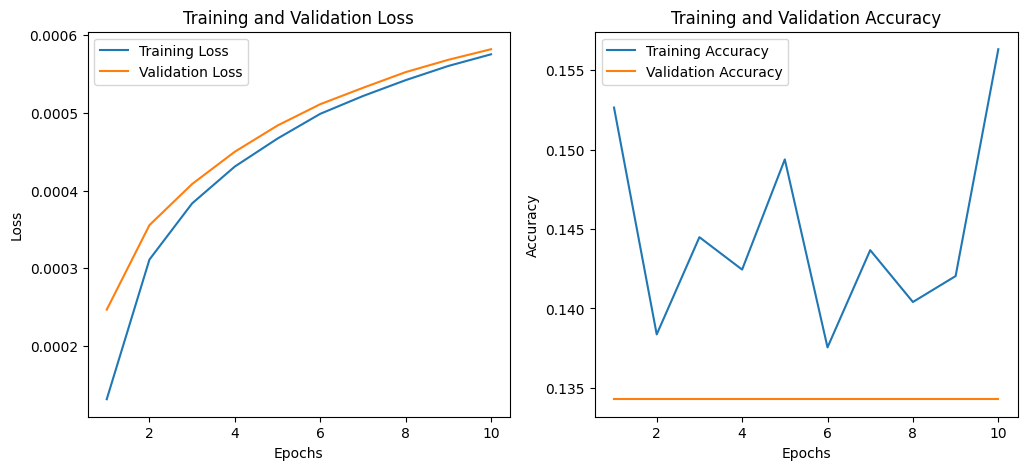

In [61]:
def plot_history(history):
    # Get the training history
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    accuracy = history.history['categorical_accuracy']
    val_accuracy = history.history['val_categorical_accuracy']

    # Plot the training history
    epochs_range = range(1, len(loss) + 1)
    plt.figure(figsize=(12, 5))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, accuracy, label='Training Accuracy')
    plt.plot(epochs_range, val_accuracy, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.show()

# Plot training history
plot_history(history)

In [62]:
# Save history to a text file
with open('training_history.txt', 'w') as file:
    file.write(str(history.history))